## Bloom and Cukoo filter's Performance Evaluation

In [1]:
from lsm_tree.GenOne.lsm_tree_cuckoo_filter_mem import LSMTreeCuckoo
from lsm_tree.GenOne.lsm_tree_bloom_filter_mem import LSMTreeBloom
from lsm_tree.GenOne.lsm_tree_original import LSMTree
from tqdm import tqdm
from statistics import stdev, mean
from pympler import asizeof

# import cProfile
# import pstats
# import snakeviz

import pandas as pd
import pyarrow.parquet as pq
import sys
import numpy as np
import time
import random
import pickle
import matplotlib.pyplot as plt
import psutil
import os

## Loading DataSet

In [2]:
df_parquet = pq.read_table('Data/2019-01-01_performance_fixed_tiles.parquet').to_pandas()

In [3]:
SEGMENTS_DIRECTORY_CKF = 'segments/cuckoo/'
SEGMENT_BASENAME_CKF = 'LSMTreeCuckoo'
WAL_BASENAME_CKF = 'wal_file_cuckoo'

SEGMENTS_DIRECTORY_BF = 'segments/bloom/'
SEGMENT_BASENAME_BF = 'LSMTreeBloom'
WAL_BASENAME_BF = 'wal_file_bloom'

size = sys.getsizeof(df_parquet[['quadkey','avg_d_kbps']])/1000000
print('Whole DataFrame      : ',size , len(df_parquet))

Whole DataFrame      :  395.040068 4877036


In [4]:
df_parquet['hashed_vals'] = df_parquet['tile'].apply(lambda x: abs(hash(x)))
df_parquet.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,hashed_vals
0,0231113112003202,"POLYGON((-90.6591796875 38.4922941923613, -90....",66216,12490,13,28,4,5192113336454434242
1,1322111021111001,"POLYGON((110.352172851562 21.2893743558604, 11...",102598,37356,13,15,4,6336983917764005744
2,3112203030003110,"POLYGON((138.592529296875 -34.9219710361638, 1...",24686,18736,18,162,106,1018543572858594839
3,0320000130321312,"POLYGON((-87.637939453125 40.225024210605, -87...",17674,13989,78,364,4,5869182951771310527
4,0320001332313103,"POLYGON((-84.7430419921875 38.9209554204673, -...",441192,218955,22,14,1,41738412402490387


In [5]:
cardinality = df_parquet['hashed_vals'].nunique()/len(df_parquet)
cardinality

1.0

## Functions For Evaluating

In [6]:
def reset_lsm(batch_size, lvl_list, fpp, time_th):
    
    !rm segments/cuckoo/*
    !rm segments/bloom/*
    !rm segments/cuckoo/cuckoo_filters/*
    !rm segments/bloom/bloom_filters/*
    
    lsm_ckf = LSMTreeCuckoo(SEGMENT_BASENAME_CKF, SEGMENTS_DIRECTORY_CKF, WAL_BASENAME_CKF)
    lsm_ckf.set_size_threshold(batch_size)
    lsm_ckf.set_ckf_fpp(fpp)
    lsm_ckf.set_time_threshold(time_th)
    lsm_ckf.set_levels_threshold(lvl_list[0], lvl_list[1])

    lsm_bf = LSMTreeBloom(SEGMENT_BASENAME_BF, SEGMENTS_DIRECTORY_BF, WAL_BASENAME_BF)
    lsm_bf.set_size_threshold(batch_size)
    lsm_bf.set_bf_fpp(fpp)
    lsm_bf.set_time_threshold(time_th)
    # lsm_bf.set_levels_threshold(lvl_list[0], lvl_list[1])
    
    return lsm_ckf, lsm_bf

def insert_testing(lsm, df):
    insertion_time = []
    for num, row in enumerate(df.iterrows()):
        start_time = time.time()
        lsm.db_set(str(row[1][-1]), str(row[1][1]))   
        end_time = time.time()
        insertion_time.append(end_time - start_time)
    insertion_time = remove_outliers_zscore(insertion_time)
    return insertion_time

def query_testing(lsm, val_list, test_size):
    time_list = []
    for val in val_list[:test_size]:
        start_time = time.time()
        lsm.db_get(val)    
        end_time = time.time()
        time_list.append(end_time - start_time)
    time_list = remove_outliers_zscore(time_list)
    return time_list

def deletion_testing(lsm, val_list, test_size):
    time_list = []
    del_list = []
    for val in val_list[:test_size]:
        start_time = time.time()
        lsm.db_del(val)    
        end_time = time.time()
        time_list.append(end_time - start_time)    
        del_list.append(val)
    time_list = remove_outliers_zscore(time_list)
    return time_list, del_list

def remove_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    filtered_data = [x for x, z in zip(data, z_scores) if abs(z) < threshold]
    return filtered_data

## Performance Evaluation

### Query & Deletion Evaluation

In [7]:
insert_range        = [100000,  150000, 200000, 250000,  300000,   350000]
query_del_test_list = [10000,     15000,  20000,  25000,   30000,   35000] 
query_del_ranges    = ['10k',     '15k',  '20k',  '25k',   '30k',   '35k'] 
batch_size          = [25000,     30000,  35000,  40000,   45000,   50000] 
lvl_list            = [[10,20],[20,40],[40,80],[50,100],[60,120],[70,140]]

fpp = 0.1
df = df_parquet
time_th = 0.05

len(insert_range), len(query_del_test_list), len(query_del_ranges), len(batch_size), len(lvl_list)

(6, 6, 6, 6, 6)

In [8]:
query_bef_results = {}
deletion_results = {}
query_aft_results = {}

In [7]:
for index, insert_num in tqdm(enumerate(insert_range[:1])):
    
    lsm_ckf , lsm_bf = reset_lsm(batch_size[index], lvl_list[index], fpp, time_th)
    
    print(f'Insertion Test {index+1} for {insert_num} Keys Starts!!')
    for row in df.iloc[:insert_num].iterrows():
        lsm_bf.db_set(str(row[1][-1]), str(row[1][1]))
        lsm_ckf.db_set(str(row[1][-1]), str(row[1][1]))
    print(lsm_bf.bfs_in_memory)
        
    query_list = df_parquet['hashed_vals'].iloc[:insert_num].tolist()
    random.shuffle(query_list)
    query_list = [str(element) for element in query_list]
    
    print(f'Query Before Test {index+1} for {insert_num} Keys Starts!!')
    query_bef_results[str(insert_num)] = (query_testing(lsm_bf, query_list, query_del_test_list[index]),)
    query_bef_results[str(insert_num)] += (query_testing(lsm_ckf, query_list, query_del_test_list[index]),)

    print(f'Deletion Test {index+1} for {insert_num} Keys Starts!!')
    del_bf, del_list_bf = deletion_testing(lsm_bf, query_list, query_del_test_list[index])
    deletion_results[str(insert_num)] =(del_bf,)
    del_ckf, del_list_ckf,= deletion_testing(lsm_ckf, query_list, query_del_test_list[index])
    deletion_results[str(insert_num)] += (del_ckf,)

    print(f'Query After Test {index+1} for {insert_num} Keys Starts!!')
    query_aft_results[str(insert_num)]  = (query_testing(lsm_bf, del_list_bf, query_del_test_list[index]),)
    query_aft_results[str(insert_num)] += (query_testing(lsm_ckf, del_list_ckf, query_del_test_list[index]),)

In [ ]:
with open('query_bef_results_org', 'wb') as b:
    pickle.dump(query_bef_results, b)
    
with open('deletion_results_org', 'wb') as b:
    pickle.dump(deletion_results, b)
    
with open('query_aft_results_org', 'wb') as b:
    pickle.dump(query_aft_results, b)

### Insertion Evaluation 

In [12]:
fpp = 0.1
df = df_parquet
time_th = 0.05

insert_ranges       = [25000  ,  50000,  100000,  200000,   400000,   800000,  1600000] #, 3200000]
insert_ranges_ticks = ['25k'  ,'50k'  ,'100k'  ,'200k'  ,'400k'   , '800k'  ,  '1600k'] #  ,  '3200k']
batch_size          = [2500   ,   5000,   10000,   20000,    40000,    80000,   160000] # ,   360000] 
lvl_list            = [[20,40],[40,80],[60,120],[80,160],[100,200],[120,240],[140,300]] # ,[150,310]]

len(insert_ranges), len(insert_ranges_ticks), len(batch_size), len(lvl_list)

(7, 7, 7, 7)

In [ ]:
inserts_results = {}
for batch_num, insert_num, lvl in tqdm(zip(batch_size, insert_ranges, lvl_list)):
    
    lsm_ckf , lsm_bf = reset_lsm(batch_num, lvl, fpp, time_th)
    
    print(f'{insert_num} Insertion Test Starts!!')
    insertion_bf = insert_testing(lsm_bf, df.iloc[:insert_num])
    inserts_results[str(insert_num)] = (insertion_bf,)
    insertion_ckf = insert_testing(lsm_ckf, df.iloc[:insert_num])
    inserts_results[str(insert_num)] += (insertion_ckf,)

## Memory Test

In [285]:
fpp = 0.05
df = df_parquet
time_th = 0.014

insert_ranges       = [i for i in range(250000,3750000,250000)]
batch_size          = [i for i in range(25000,375000,25000)]
lvl_list            = [[x, 2*x] for x in range(20, 140,9)]

memory = {}
file_count = {}
start = 5
stop = 6
step = None

for batch_num, insert_num, lvl in zip(batch_size[start:stop:step], insert_ranges[start:stop:step], lvl_list[start:stop:step]):
    print(f'{insert_num} Insertion Test Starts!!')
    lsm_ckf , lsm_bf = reset_lsm(batch_num, lvl, fpp, time_th)
    for row in tqdm(df_parquet[:insert_num].iterrows()):
        lsm_bf.db_set(str(row[1][-1]), str(row[1][1]))
        lsm_ckf.db_set(str(row[1][-1]), str(row[1][1]))
    lsm_bf.save_bfs()
    lsm_ckf.save_ckfs()

1500000 Insertion Test Starts!!
rm: cannot remove 'segments/cuckoo/cuckoo_filters': Is a directory
rm: cannot remove 'segments/bloom/bloom_filters': Is a directory
rm: cannot remove 'segments/cuckoo/cuckoo_filters/*': No such file or directory
rm: cannot remove 'segments/bloom/bloom_filters/*': No such file or directory


1500000it [03:45, 6644.41it/s]


In [286]:
cuckoo_path = os.listdir('segments/cuckoo/cuckoo_filters/')[0]
cuckoo = os.path.getsize('segments/cuckoo/cuckoo_filters/'+cuckoo_path)/(1024**3)

In [287]:
cuckoo

0.0010799653828144073

In [288]:
bloom_path = os.listdir('segments/bloom/bloom_filters/')[0]
bloom = os.path.getsize('segments/bloom/bloom_filters/'+bloom_path)/(1024**3)

In [289]:
bloom

0.0011626984924077988

In [290]:
temp_dic = {}
for i in os.listdir('segments/cuckoo/'):
    if i.split('-')[0] == 'LSMTreeCuckoo':
        temp_dic[i] = os.path.getsize('segments/cuckoo/'+i)/(1024**3)
sstable = min(temp_dic.values())

In [291]:
sstable

0.028202720917761326

In [292]:
meta_dict = {}
for i in tqdm(range(10, 100010, 10)):

    sstable_file_num = int(round(i/sstable, 0))
    ckf_file_num = round(sstable_file_num*cuckoo, 2)
    bf_file_num = round(sstable_file_num*bloom, 2)

    meta_dict[i] = (sstable_file_num, bf_file_num, ckf_file_num)

100%|██████████| 10000/10000 [00:00<00:00, 443879.27it/s]


In [293]:
# meta_dict

In [294]:
def plot_memory(bf_data, ckf_data, ax0, plot_title, fpp_rate, loc=6, tick_skip=500):
    plt.figure(figsize=(8, 5))  # Adjust the figure size for better readability

    # Plotting
    plt.plot(bf_data, color='Green', linestyle='--')
    plt.plot(ckf_data, color='Orange', linestyle='--')
    plt.xlabel('Number of Filters per 1000', size=15)
    plt.ylabel('Memory Consumed (GB)', size=15)

    # Convert ax0 values to Ks (thousands) and skip every nth value
    x_ticks = [f'{val//1000}K' for val in ax0[::tick_skip]]
    plt.xticks(range(0, len(ax0), tick_skip), x_ticks, rotation=40, ha="right")

    # plt.title(f'{plot_title}', size=20)

    plt.legend(['Bloom Filter', 'Cuckoo Filter'], loc=loc)
    fig_title = ''.join(plot_title.split())
    file_name = fig_title
    plt.subplots_adjust(bottom=0.25)
    plt.savefig(f'{file_name}.png')
    plt.tight_layout()  # Ensures that labels fit within the figure
    
    plt.show()

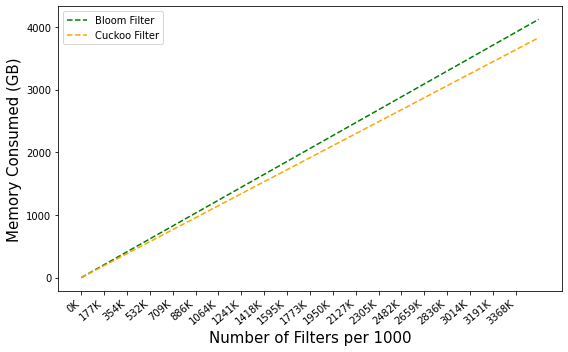

In [295]:
ssfile_disk_files = [val[0] for key, val in meta_dict.items()]
bf_memory_usage = [val[1] for key, val in meta_dict.items()]
ckf_memory_usage = [val[2] for key, val in meta_dict.items()]

plot_memory(bf_memory_usage, ckf_memory_usage, ssfile_disk_files,f'Filter Memory Usage for {int(fpp*100)} percent FPP', loc = 0, fpp_rate = str(fpp))

In [296]:
from statistics import mean, stdev, harmonic_mean

In [303]:
mean([abs(ckf-bf)/ckf for bf, ckf in zip(bf_memory_usage,ckf_memory_usage)])

0.07660656448319958

## Original (No filter LSM Tree) Insertion Test 

In [7]:
insert_range        = [100000,  150000, 200000, 250000,  300000,   350000]
query_del_test_list = [10000,     15000,  20000,  25000,   30000,   35000] 
query_del_ranges    = ['10k',     '15k',  '20k',  '25k',   '30k',   '35k'] 
batch_size          = [25000,     30000,  35000,  40000,   45000,   50000] 
lvl_list            = [[10,20],[20,40],[40,80],[50,100],[60,120],[70,140]]

fpp = 0.1
df = df_parquet
time_th = 0.05

len(insert_range), len(query_del_test_list), len(query_del_ranges), len(batch_size), len(lvl_list)

(6, 6, 6, 6, 6)

In [8]:
insertion_results = {}
query_bef_results = {}
deletion_results  = {}
query_aft_results = {}

In [10]:
for index, insert_num in tqdm(enumerate(insert_range[:])):
    
    _, _, lsm_original = reset_lsm(batch_size[index], lvl_list[index], fpp, time_th)
    
    print(f'Insertion Test {index+1} for {insert_num} Keys Starts!!')
    for row in df.iloc[:insert_num].iterrows():
        lsm_original.db_set(str(row[1][-1]), str(row[1][1]))
        
    query_list = df_parquet['hashed_vals'].iloc[:insert_num].tolist()
    random.shuffle(query_list)
    query_list = [str(element) for element in query_list]
    
    print(f'Query Before Test {index+1} for {insert_num} Keys Starts!!')
    query_bef_results[str(insert_num)] = (query_testing(lsm_original, query_list, query_del_test_list[index]),)
    
    print(f'Deletion Test {index+1} for {insert_num} Keys Starts!!')
    del_org, del_list_org = deletion_testing(lsm_original, query_list, query_del_test_list[index])
    deletion_results[str(insert_num)] =(del_org,)

    print(f'Query After Test {index+1} for {insert_num} Keys Starts!!')
    query_aft_results[str(insert_num)]  = (query_testing(lsm_original, del_list_org, query_del_test_list[index]),)

0it [00:00, ?it/s]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
Insertion Test 1 for 100000 Keys Starts!!
Query Before Test 1 for 100000 Keys Starts!!
Deletion Test 1 for 100000 Keys Starts!!
Query After Test 1 for 100000 Keys Starts!!


1it [05:44, 344.67s/it]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
Insertion Test 2 for 150000 Keys Starts!!
Query Before Test 2 for 150000 Keys Starts!!
Deletion Test 2 for 150000 Keys Starts!!
Query After Test 2 for 150000 Keys Starts!!


2it [22:09, 721.40s/it]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
Insertion Test 3 for 200000 Keys Starts!!
Query Before Test 3 for 200000 Keys Starts!!
Deletion Test 3 for 200000 Keys Starts!!
Query After Test 3 for 200000 Keys Starts!!


3it [55:58, 1119.55s/it]


In [13]:
inserts_results = {}

for batch_num, insert_num, lvl in tqdm(zip(batch_size, insert_ranges, lvl_list)):
    
    _, _, lsm_original = reset_lsm(batch_num, lvl, fpp, time_th)
    
    print(f'{insert_num} Insertion Test Starts!!')
    insertion_org = insert_testing(lsm_original, df.iloc[:insert_num])
    inserts_results[str(insert_num)] = (insertion_org,)

0it [00:00, ?it/s]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
25000 Insertion Test Starts!!


1it [00:02,  2.95s/it]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
rm: cannot remove 'segments/lsm_original/*': No such file or directory
50000 Insertion Test Starts!!


2it [00:07,  3.98s/it]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
rm: cannot remove 'segments/lsm_original/*': No such file or directory
100000 Insertion Test Starts!!


3it [00:16,  6.19s/it]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
200000 Insertion Test Starts!!


4it [00:33, 10.41s/it]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
400000 Insertion Test Starts!!


5it [01:06, 18.64s/it]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
800000 Insertion Test Starts!!


6it [02:12, 34.75s/it]

rm: cannot remove 'segments/cuckoo/*': No such file or directory
rm: cannot remove 'segments/bloom/*': No such file or directory
1600000 Insertion Test Starts!!


7it [04:24, 37.76s/it]
